# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [2]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [3]:
data, labels = load_data()
print(data)

[[ 75 101 128 ... 118  37  39]
 [110 124 144 ...  33  33  33]
 [ 77 119 142 ...  32  35  35]
 ...
 [121 147 159 ...  37  38  38]
 [ 52  53  51 ...  98 126 141]
 [125  68  60 ...  69  76  87]]


### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

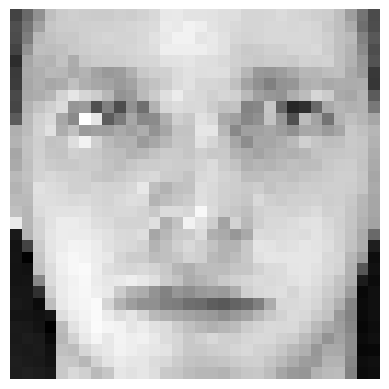

In [4]:
# Display a single example.
show_single_face(data[0, :])

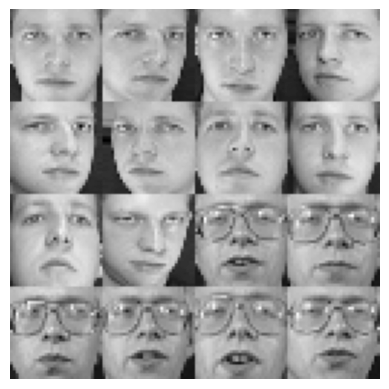

In [5]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [6]:
# normalization
data = data / 255

In [7]:
# partition
def split_data(data):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    return tr_data, tr_label, te_data, te_label

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [8]:
def l2_rls_train(data, labels, lambdas):
    """
    A summary of your function goes here.

    data: array which store the training data in the form of matrix. Each row of the matrix
    can be transformed to a face through show_single_face function.
    labels: array which store the class that the training data belongs to in the form of matrix. label[i, :] stores the 
    class of data[i, :].

    Returns: array which store the weight matrix.
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    ncol = len(data)
    X_tilde = np.hstack((np.ones((ncol, 1), dtype=int), data))
    
    # Compute the coefficient vector.
    # Compute identity matrix
    im = np.eye(X_tilde.shape[1])
    if lambdas != 0:
        #w = ((X_tilde.T @ X_tilde + lambdas * im) ** (-1)) * (X_tilde.T @ y)
        #w = (1/((X_tilde.T @ X_tilde) + (lambdas * im))) @ X_tilde.T @ y
        w = np.linalg.inv((X_tilde.T @ X_tilde) + (lambdas * im)) @ X_tilde.T @ y
    else:
        #w = np.linalg.pinv(X_tilde.T) * y
        w = np.linalg.pinv(X_tilde) @ y
    
    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [9]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: array which store the test data in the form of matrix. Each row of the matrix
    can be transformed to a face through show_single_face function.
    w: array which stores the weight matrix.

    Returns: array which store the result of prediction function of each testing data. 
    """
    # Compute the prediction.
    # Expand X with a column of ones.
    ncol = len(data)
    data = np.hstack((np.ones((ncol, 1), dtype=int), data))
    predicted_y = data @ w
        
    return predicted_y

#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [10]:
# Your code goes here

# Get the training and testing set "1" and "30"
def get1And30(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]

    tr_label2 = np.ones((6, 1))
    for i in range(3):
        tr_label2[i][0] = -1

    te_label2 = np.ones(14, dtype=int)
    for i in range(7):
        te_label2[i] = -1
    return tr_data2, tr_label2, te_data2, te_label2

def predict(tr_data2, tr_label2, te_data2, te_label2, lambdas):
    correct = 0
    w = l2_rls_train(tr_data2, tr_label2, lambdas)
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 0:
            y[i] = -1
        else:
            y[i] = 1
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

errorListTraining = []
errorListTesting = []
for i in range(50):
    tr_data2, tr_label2, te_data2, te_label2 = get1And30(data)
    # testing error
    error = predict(tr_data2, tr_label2, te_data2, te_label2, 0)
    errorListTesting.append(error)
    # training error
    tr_label2 = [-1, -1, -1, 1, 1, 1]
    error = predict(tr_data2, tr_label2, tr_data2, tr_label2, 0)
    errorListTraining.append(error)

Repeat the same experiment for classifier 2.

In [11]:
# Your code goes here
# Your code goes here
# Get the training and testing set "1" and "30"
def get1And302(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]

    tr_label2 = np.ones((6, 1))
    for i in range(3):
        tr_label2[i][0] = 0

    te_label2 = np.ones(14, dtype=int)
    for i in range(7):
        te_label2[i] = 0
    return tr_data2, tr_label2, te_data2, te_label2

def predict2(tr_data2, tr_label2, te_data2, te_label2, lambdas):
    correct = 0
    w = l2_rls_train(tr_data2, tr_label2, lambdas)
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 0.5:
            y[i] = 0
        else:
            y[i] = 1
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

errorListTraining2 = []
errorListTesting2 = []

for i in range(50):
    tr_data2, tr_label2, te_data2, te_label2 = get1And302(data)
    # testing error
    error = predict2(tr_data2, tr_label2, te_data2, te_label2, 0.5)
    errorListTesting2.append(error)
    # training error
    tr_label2 = [0, 0, 0, 1, 1, 1]
    error = predict2(tr_data2, tr_label2, tr_data2, tr_label2, 0.5)
    errorListTraining2.append(error)

Repeat the same experiment for classifier 3.

In [12]:
# Your code goes here
# Your code goes here
# Get the training and testing set "1" and "30"
def get1And303(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]

    tr_label2 = np.ones((6, 1))
    for i in range(3):
        tr_label2[i+3][0] = 30

    te_label2 = np.ones(14, dtype=int)
    for i in range(7):
        te_label2[i+7] = 30
    return tr_data2, tr_label2, te_data2, te_label2

def predict3(tr_data2, tr_label2, te_data2, te_label2, lambdas):
    correct = 0
    w = l2_rls_train(tr_data2, tr_label2, lambdas)
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 15.5:
            y[i] = 1
        else:
            y[i] = 30
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

errorListTraining3 = []
errorListTesting3 = []

for i in range(50):
    tr_data2, tr_label2, te_data2, te_label2 = get1And303(data)
    # testing error
    error = predict3(tr_data2, tr_label2, te_data2, te_label2, 15.5)
    errorListTesting3.append(error)
    # training error
    tr_label2 = [1, 1, 1, 30, 30, 30]
    error = predict3(tr_data2, tr_label2, tr_data2, tr_label2, 15.5)
    errorListTraining3.append(error)

Print out the mean and the std values of the test errors of the three classifiers.

In [13]:
# Your code goes here
print("Experiment 1")
print("Mean of test errors", np.mean(errorListTesting))
print("Standard deviation of test errors", np.std(errorListTesting))
print(".................")
print("Experiment 2")
print("Mean of test errors", np.mean(errorListTesting2))
print("Standard deviation of test errors", np.std(errorListTesting2))
print(".................")
print("Experiment 3")
print("Mean of test errors", np.mean(errorListTesting3))
print("Standard deviation of test errors", np.std(errorListTesting3))

Experiment 1
Mean of test errors 0.06714285714285714
Standard deviation of test errors 0.08853685961340667
.................
Experiment 2
Mean of test errors 0.08285714285714285
Standard deviation of test errors 0.08373914794144482
.................
Experiment 3
Mean of test errors 0.10571428571428569
Standard deviation of test errors 0.1099536080279649


#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [14]:
# Your code goes here
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

In [15]:
# Your code goes here

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

In [16]:
# Your code goes here

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [17]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

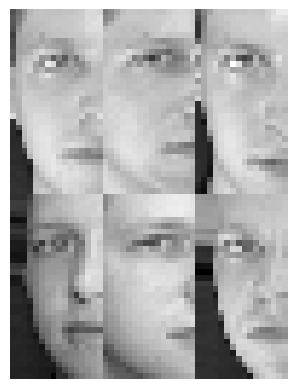

In [18]:
show_split_faces(left[:6, :], num_per_row=3)

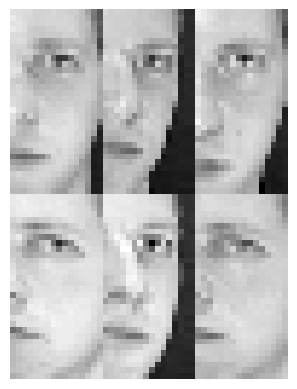

In [19]:
show_split_faces(right[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [20]:
# Your code goes here
# Get the training and testing data
tr_data, tr_label, te_data, te_label = split_data(data)
leftTrain, rightTrain = split_left_right(tr_data)
leftTest, rightTest = split_left_right(te_data)

# train and test data
w = l2_rls_train(leftTrain, rightTrain, 0)
y = l2_rls_predict(w, leftTest)
real = join_left_right(leftTest, rightTest)
new = join_left_right(leftTest, y)

# Absolute error
mape = np.mean(np.abs((rightTest - y) / rightTest)) * 100
print("Mean absolute percentage error = ", mape, "%")

Mean absolute percentage error =  21.582115056368366 %


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

The first row is Ground truth face and the second row is completed face:



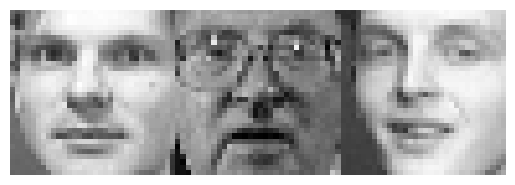

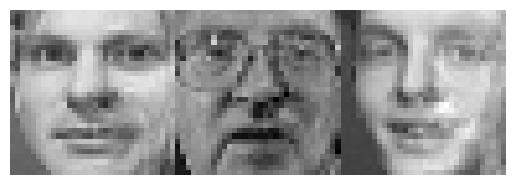

In [21]:
# Your code goes here
randface = np.random.randint(280, size=3)
print("The first row is Ground truth face and the second row is completed face:\n")
show_faces(real[randface, :], num_per_row=3)
show_faces(new[randface, :], num_per_row=3)

#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [22]:
def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: array which store the training data in the form of matrix. Each row of the matrix
    can be transformed to a face through show_single_face function.
    labels: array which store the class that the training data belongs to in the form of matrix. label[i, :] stores the 
    class of data[i, :].
    
    Returns: 2 array. The first stores the cost of each iteration and the second store the weight vector of each iteration.
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    ncol = len(data)
    X_tilde = np.hstack((np.ones((ncol, 1), dtype=int), data))
    
    # Weight initialization
    #w = ((X_tilde.T @ X_tilde) ** (-1)) @ X_tilde.T @ y
    #w = X_tilde.T @ np.linalg.inv(X_tilde @ X_tilde.T) @ y
    w = np.zeros(1025)
    #w = X_tilde.T @ ((X_tilde @ X_tilde.T) ** (-1)) @ y
    #print(w)
    
    
    # GD update of weights
    cost_all = []
    w_all = []
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        # (X.T@X)**(-1) @ X.T @ y
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        #cost = calcost(w, X_tilde, y)
        cost = 0.5 * np.sum((w @ X_tilde.T - y)**(2))
        # Weight update
        w = w - learning_rate * gd
        #print(cost)
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)
    
    
    # Return model parameters.
    return cost_all, w_all

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


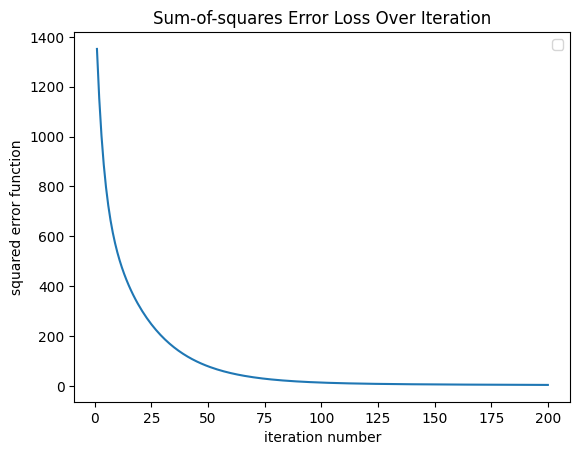

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


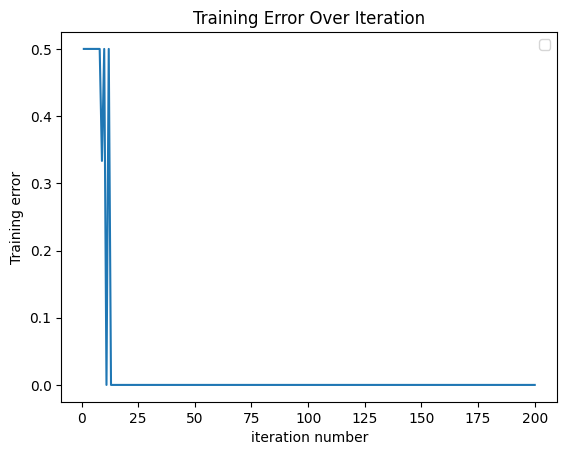

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


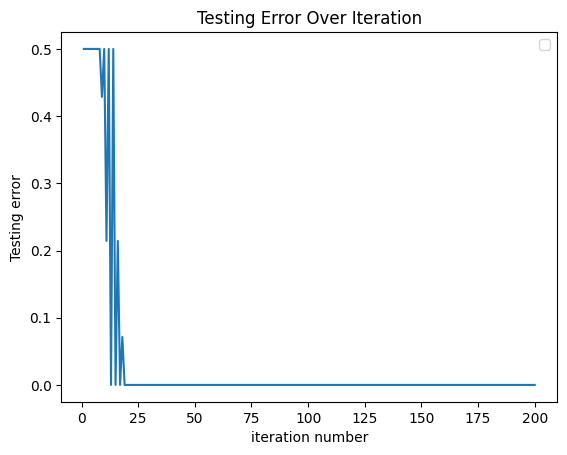

In [28]:
# Your code goes here
def get1And30gd(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]
    tr_label2 = tr_label[np.where((tr_label==1) | (tr_label==30))]
    te_label2 = te_label[np.where((te_label==1) | (te_label==30))]
    return tr_data2, tr_label2, te_data2, te_label2

tr_data2, tr_label2, te_data2, te_label2 = get1And30gd(data)
learning_rate = 10**(-3)
loop = 200
cost_all, w_all = lls_gd_train(tr_data2, tr_label2, learning_rate, loop)

def predictgd(w, te_data2, te_label2):
    correct = 0
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 15.5:
            y[i] = 1
        else:
            y[i] = 30
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

# The change of your sum-of-squares error loss that you minimise (1st graph)
datum = np.arange(1, 201, 1)
plt.plot(datum, cost_all,label='')
plt.xlabel('iteration number')
plt.ylabel('squared error function')
plt.title('Sum-of-squares Error Loss Over Iteration')
plt.legend()
plt.show()

# the change of the classification accuracy for training samples over iterations (2rd graph)
errorListGdTrain = []
for i in w_all:
    error = predictgd(i, tr_data2, tr_label2)
    errorListGdTrain.append(error)

datum = np.arange(1, 201, 1)
plt.plot(datum, errorListGdTrain,label='')
plt.xlabel('iteration number')
plt.ylabel('Training error')
plt.title('Training Error Over Iteration')
plt.legend()
plt.show()

# the change of the classification accuracy for test samples over iterations (3rd graph)
errorListGdTest = []
for i in w_all:
    error = predictgd(i, te_data2, te_label2)
    errorListGdTest.append(error)

    datum = np.arange(1, 201, 1)
plt.plot(datum, errorListGdTest)
plt.xlabel('iteration number')
plt.ylabel('Testing error')
plt.title('Testing Error Over Iteration')
plt.legend()
plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

/var/folders/j3/1gbw2lcn4r9b5lc3dbxfpzsr0000gn/T/ipykernel_47241/806446716.py:38: RuntimeWarning: overflow encountered in square
  cost = 0.5 * np.sum((w @ X_tilde.T - y)**(2))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


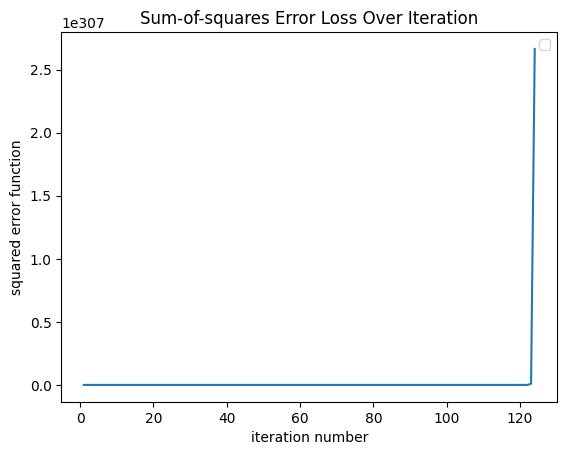

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


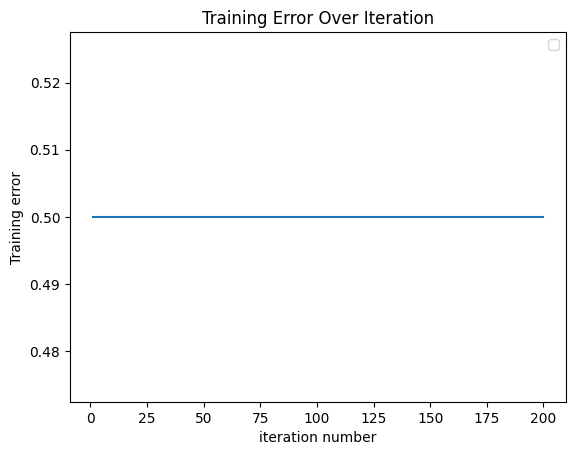

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


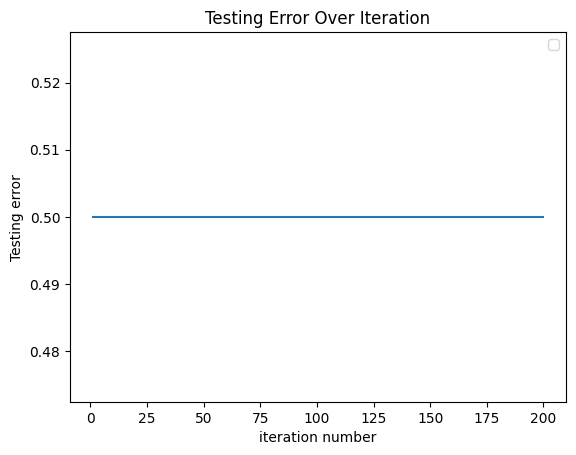

In [29]:
# Your code goes here
# Your code goes here
def get1And30gd(data):
    tr_data, tr_label, te_data, te_label = split_data(data)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]
    tr_label2 = tr_label[np.where((tr_label==1) | (tr_label==30))]
    te_label2 = te_label[np.where((te_label==1) | (te_label==30))]
    return tr_data2, tr_label2, te_data2, te_label2

def predictgd(w, te_data2, te_label2):
    correct = 0
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 15.5:
            y[i] = 1
        else:
            y[i] = 30
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

tr_data2, tr_label2, te_data2, te_label2 = get1And30gd(data)
learning_rate = 10**(-2)
loop = 200
cost_all, w_all = lls_gd_train(tr_data2, tr_label2, learning_rate, loop)

# The change of your sum-of-squares error loss that you minimise (1st graph)
datum = np.arange(1, 201, 1)
plt.plot(datum, cost_all,label='')
plt.xlabel('iteration number')
plt.ylabel('squared error function')
plt.title('Sum-of-squares Error Loss Over Iteration')
plt.legend()
plt.show()

# the change of the classification accuracy for training samples over iterations (2rd graph)
errorListGdTrain = []
for i in w_all:
    error = predictgd(i, tr_data2, tr_label2)
    errorListGdTrain.append(error)

datum = np.arange(1, 201, 1)
plt.plot(datum, errorListGdTrain,label='')
plt.xlabel('iteration number')
plt.ylabel('Training error')
plt.title('Training Error Over Iteration')
plt.legend()
plt.show()

# the change of the classification accuracy for test samples over iterations (3rd graph)
errorListGdTest = []
for i in w_all:
    error = predictgd(i, te_data2, te_label2)
    errorListGdTest.append(error)

    datum = np.arange(1, 201, 1)
plt.plot(datum, errorListGdTest,label='')
plt.xlabel('iteration number')
plt.ylabel('Testing error')
plt.title('Testing Error Over Iteration')
plt.legend()
plt.show()

#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [ ]:
# Your code goes here
def lls_sgd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: array which store 1 training data in the form of matrix.
    labels: array which store the class that the training data belongs to in the form of matrix. label[i, :] stores the 
    class of data[i, :].
    
    Returns: 2 array. The first stores the cost of each iteration and the second store the weight vector of each iteration.
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    ncol = len(data)
    X_tilde = np.hstack((np.ones((ncol, 1), dtype=int), data))
    w = np.zeros(1025)
    
    # Get array of single data
    X_tilde = np.array([X_tilde[0]])
    y = np.array([y[0]])
    
    # GD update of weights
    cost_all = []
    w_all = []
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        # (X.T@X)**(-1) @ X.T @ y
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        #cost = calcost(w, X_tilde, y)
        cost = 0.5 * np.sum((w @ X_tilde.T - y)**(2))
        # Weight update
        w = w - learning_rate * gd
        #print(cost)
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)
    
    
    # Return model parameters.
    return cost_all, w_all

### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


No handles with labels found to put in legend.


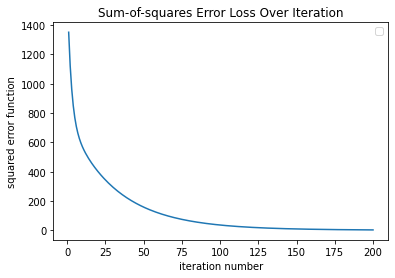

No handles with labels found to put in legend.


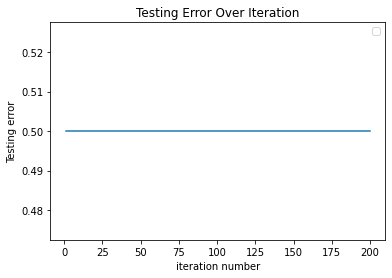

In [ ]:
# Your code goes here

def predictsgd(w, te_data2, te_label2):
    correct = 0
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 15.5:
            y[i] = 1
        else:
            y[i] = 30
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

#tr_data2, tr_label2, te_data2, te_label2 = get1And30sgd(data)
learning_rate = 10**(-3)
loop = 200
cost_all, w_all = lls_sgd_train(tr_data2, tr_label2, learning_rate, loop)
# The change of your sum-of-squares error loss that you minimise (1st graph)
datum = np.arange(1, 201, 1)
plt.plot(datum, cost,label='')
plt.xlabel('iteration number')
plt.ylabel('squared error function')
plt.title('Sum-of-squares Error Loss Over Iteration')
plt.legend()
plt.show()

# the change of the classification accuracy for training samples over iterations (2rd graph)
errorListSgdTest = []
for i in w_all:
    error = predictsgd(i, te_data2, te_label2)
    errorListSgdTest.append(error)

datum = np.arange(1, 201, 1)
plt.plot(datum, errorListSgdTest,label='')
plt.xlabel('iteration number')
plt.ylabel('Testing error')
plt.title('Testing Error Over Iteration')
plt.legend()
plt.show()

#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.